In [18]:
# basics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# penny
import pennylane as qml
from pennylane.transforms import compile
from pennylane.math import fidelity_statevector as fidelity_penny
# qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Gate
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_circuit_layout, circuit_drawer
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import state_fidelity as fidelity_qiskit
from math import pi
import copy

In [2]:
[ds] = qml.data.load("ketgpt")
@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 999
    for op in ds.circuits[0]:
        qml.apply(op)
    return qml.state()

In [3]:
def summary_penny(circuit):
    obj = qml.specs(circuit)()['resources']
    return [obj.num_wires, obj.num_gates, obj.gate_sizes[1], obj.gate_sizes[2], obj.depth]
    
summary_penny(circuit)

[13, 205, 116, 89, 72]

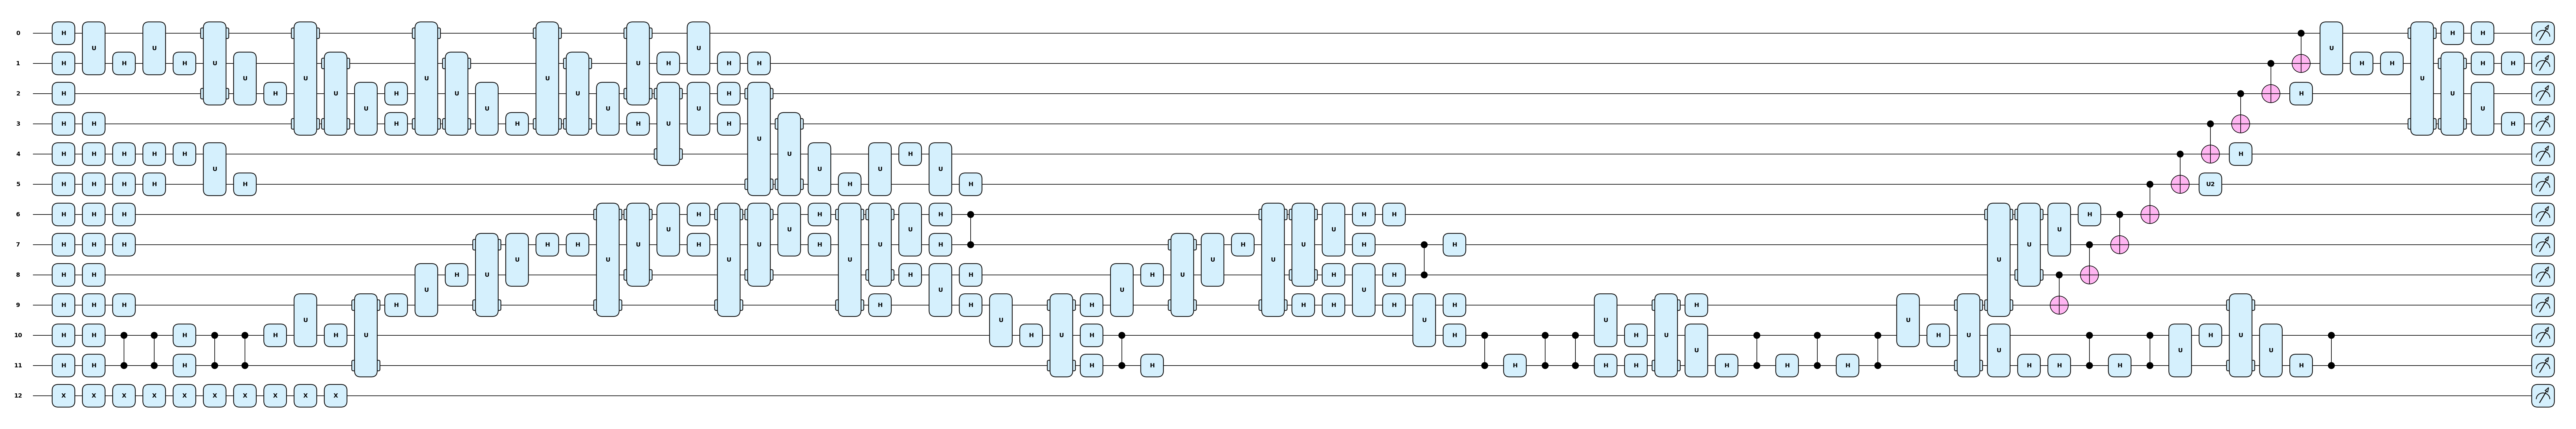

In [4]:
qml.draw_mpl(circuit, style='pennylane')()
plt.show()

In [5]:
# compile
transpiled_circuit = compile(circuit)
summary_penny(transpiled_circuit)

[12, 147, 64, 83, 60]

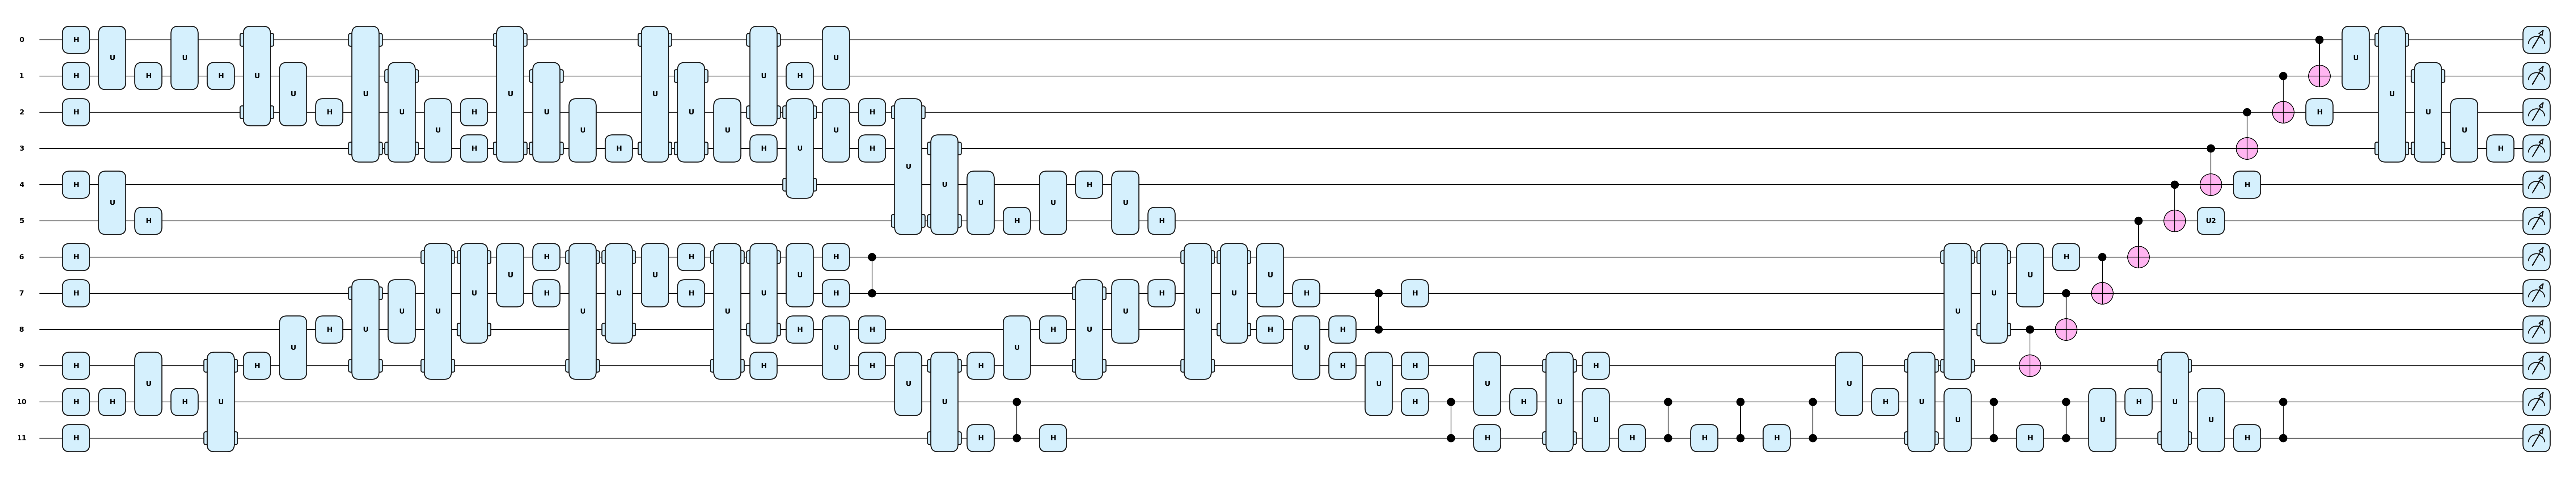

In [6]:
qml.draw_mpl(transpiled_circuit, style='pennylane')()
plt.show()

In [7]:
gate_name = []
gate_info = []
for op in ds.circuits[0]:
    name = op.name
    gate_name.append(name)
    wires = [int(w) for w in op.wires]
    params = op.parameters
    gate_info.append({
        "name": name,
        "wires": wires,
        "params": params,
    })
    
gate_info[:3]

[{'name': 'Hadamard', 'wires': [0], 'params': []},
 {'name': 'Hadamard', 'wires': [1], 'params': []},
 {'name': 'Hadamard', 'wires': [2], 'params': []}]

In [8]:
def to_qiskit(dict_elem):
    name = dict_elem['name']
    wire = dict_elem['wires']
    param = dict_elem['params']
    if name == 'Hadamard':
        qc.h(wire[0])
    if name == 'PauliX':
        qc.x(wire[0])
    if name == 'PauliY':
        qc.y(wire[0])
    if name == 'PauliZ':
        qc.z(wire[0])
    if name == 'CNOT':
        qc.cx(wire[0],wire[1])
    if name == 'CX':
        qc.cx(wire[0],wire[1])  
    if name == 'CY':
        qc.cy(wire[0],wire[1])  
    if name == 'CZ':
        qc.cz(wire[0],wire[1])    
    if name == 'QubitUnitary':
        qc.append(UnitaryGate(param[0]),wire)
    if name == 'U2':
        qc.u(pi/2, param[0], param[1], wire[0])

In [22]:
sample_q_num = qml.specs(circuit)()['resources'].num_wires
qc = QuantumCircuit(sample_q_num)
for dict_elem in gate_info:
    to_qiskit(dict_elem)

In [23]:
# Use AerSimulator to extend the circuit
simulator = AerSimulator()
qc.save_statevector()  # Now this works!

# Run the simulation
result = simulator.run(qc).result()
statevector = result.data()['statevector']
ref_state = statevector.data

In [10]:
def summary_qiskit(qc):
    counts = {"1-qubit": 0, "2-qubit": 0}
    for inst in qc.data:
        if isinstance(inst.operation, Gate):  
            num_qubits = len(inst.qubits)
            if num_qubits == 1:
                counts["1-qubit"] += 1
            elif num_qubits == 2:
                counts["2-qubit"] += 1
    return [qc.num_qubits, qc.size(), counts['1-qubit'], counts['2-qubit'], qc.depth()]

In [11]:
# qiskit compiler
def qiskit_transpiler(qc, level=2):
    # Transpile with qiskit
    # qc.save_statevector()
    backend = Aer.get_backend('qasm_simulator')
    transpiled_qiskit = transpile(qc, backend, optimization_level=level)
    result = backend.run(transpiled_qiskit).result()
    transpiled_state = result.get_statevector()
    return transpiled_qiskit

In [12]:
def penny_from_qiskit(qc):
    pc_penny = qml.from_qiskit(qc)
    num_q = qc.num_qubits
    dev = qml.device("default.qubit", wires=num_q)
    
    @qml.qnode(dev)
    def circuit():
        pc_penny(wires=range(num_q))
        return qml.state()

    return circuit

penny_from_qiskit(qc)

<QNode: device='<default.qubit device (wires=13) at 0x184b181e680>', interface='auto', diff_method='best'>

In [25]:
def make_table(qc): # takes qiskit circuits
    df = pd.DataFrame(columns=['original','qiskit_0','qiskit_1','qiskit_2','qiskit_3','penny'])
    
    df['original'] = summary_qiskit(qc)
    qc0 = copy.deepcopy(qc)
    qc1 = copy.deepcopy(qc)
    qc2 = copy.deepcopy(qc)
    qc3 = copy.deepcopy(qc)

    transpiled_qiskit_0 = qiskit_transpiler(qc0,0)
    df['qiskit_0'] = summary_qiskit(transpiled_qiskit_0)        
    transpiled_qiskit_1 = qiskit_transpiler(qc1,1)
    df['qiskit_1'] = summary_qiskit(transpiled_qiskit_1)
    transpiled_qiskit_2 = qiskit_transpiler(qc2,2)
    df['qiskit_2'] = summary_qiskit(transpiled_qiskit_2)        
    transpiled_qiskit_3 = qiskit_transpiler(qc3,3)
    df['qiskit_3'] = summary_qiskit(transpiled_qiskit_3)
    
    penny = penny_from_qiskit(qc)
    transpiled_penny  = compile(penny)
    df['penny'] = summary_penny(transpiled_penny)
    
    df.index = ['qubits', 'gates', '1q gates', '2q gates', 'depth']
    print(df)
    return transpiled_qiskit_0, transpiled_qiskit_1, transpiled_qiskit_2, transpiled_qiskit_3, transpiled_penny, df

In [26]:
transpiled_qiskit_0, transpiled_qiskit_1, transpiled_qiskit_2, transpiled_qiskit_3, transpiled_penny, df = make_table(qc)

          original  qiskit_0  qiskit_1  qiskit_2  qiskit_3  penny
qubits          13        13        13        13        13     12
gates          205       205       145       145       145    147
1q gates       116       116        62        62        62     64
2q gates        89        89        83        83        83     83
depth           72        72        59        59        59     60


C:\Users\syj43\AppData\Local\Programs\Python\Python310\lib\site-packages\pennylane_qiskit\converter.py:581: UserWarning: pennylane_qiskit.converter: The SaveStatevector instruction is not supported by PennyLane, and has not been added to the template.
  warnings.warn(


In [27]:
def summary_qiskit_fidelity(transpiled_circuit, ref_state):
    backend = Aer.get_backend('qasm_simulator')
    result = backend.run(transpiled_circuit).result()
    qiskit_state = result.get_statevector()
    return fidelity_qiskit(ref_state, qiskit_state.data)

In [28]:
# New row as a dictionary
new_row = {'original':'-', 
           'qiskit_0':summary_qiskit_fidelity(transpiled_qiskit_0, ref_state), 
           'qiskit_1':summary_qiskit_fidelity(transpiled_qiskit_1, ref_state), 
           'qiskit_2':summary_qiskit_fidelity(transpiled_qiskit_2, ref_state), 
           'qiskit_3':summary_qiskit_fidelity(transpiled_qiskit_3, ref_state), 
           'penny':'-'}
df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
print(df)

  original  qiskit_0  qiskit_1  qiskit_2  qiskit_3 penny
0       13      13.0      13.0      13.0      13.0    12
1      205     205.0     145.0     145.0     145.0   147
2      116     116.0      62.0      62.0      62.0    64
3       89      89.0      83.0      83.0      83.0    83
4       72      72.0      59.0      59.0      59.0    60
5        -       1.0       1.0       1.0       1.0     -
